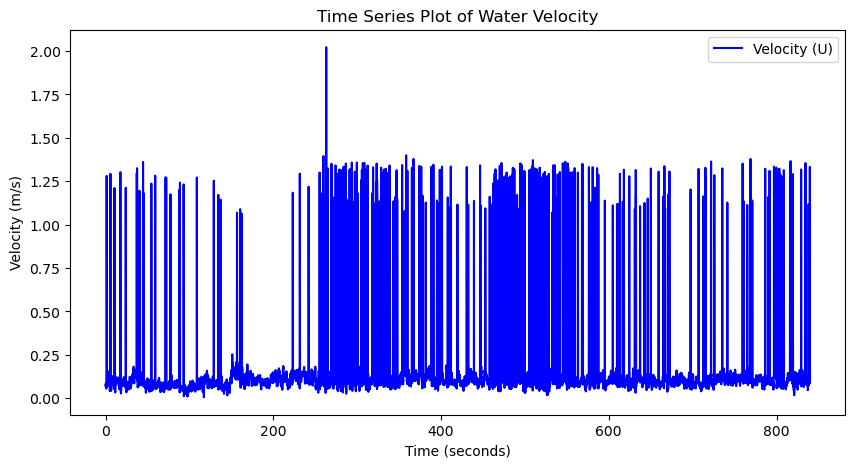

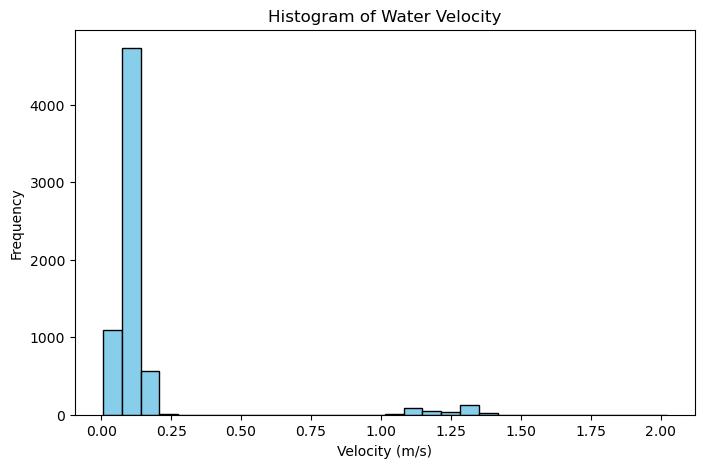

4.96% of the data set to NaN


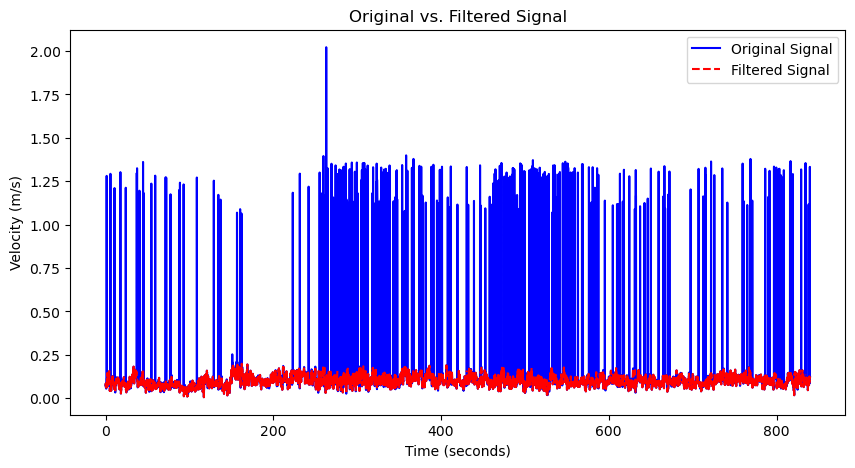

Bad Indices = 322


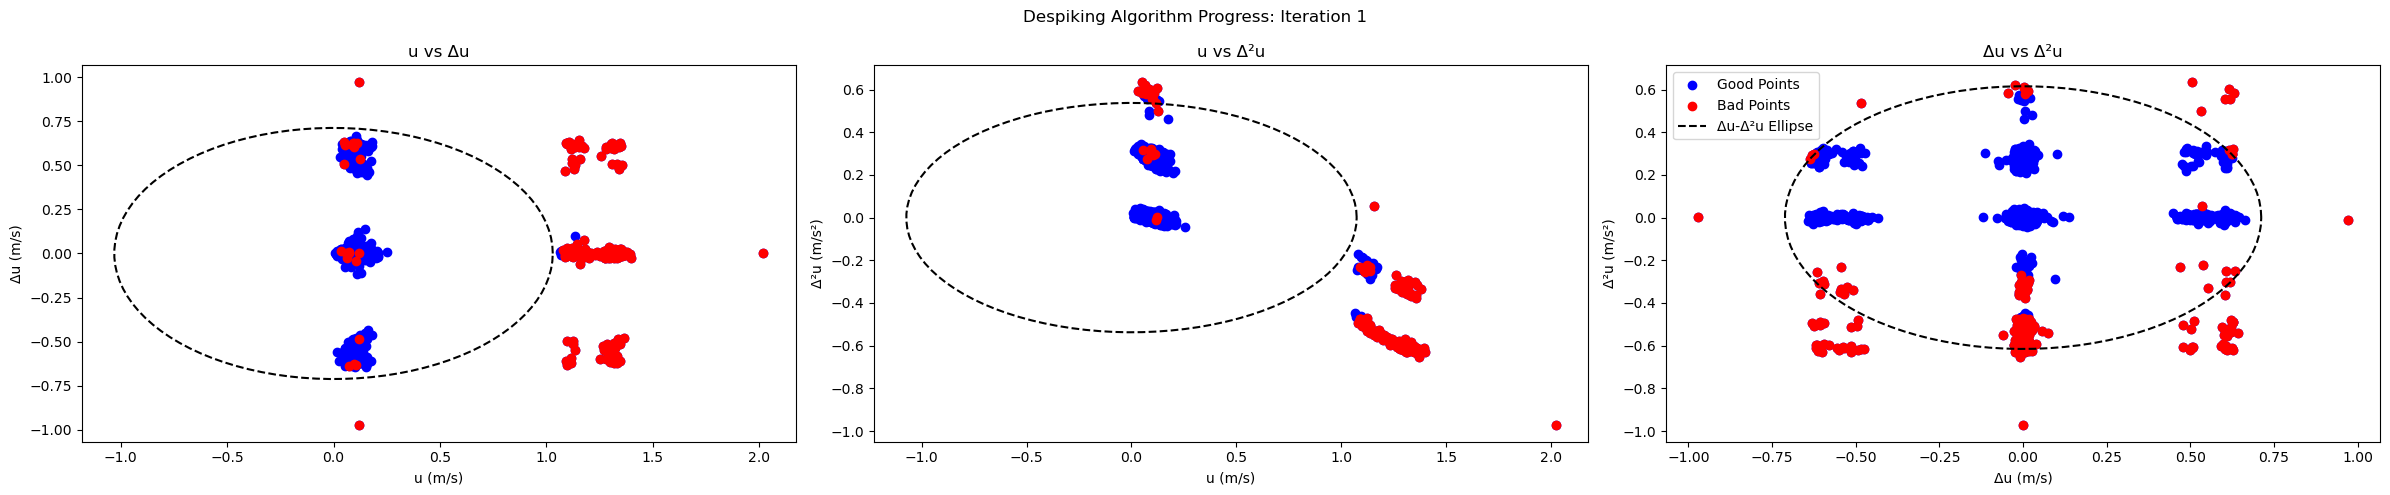

Iteration 1 complete.
Bad Indices = 113


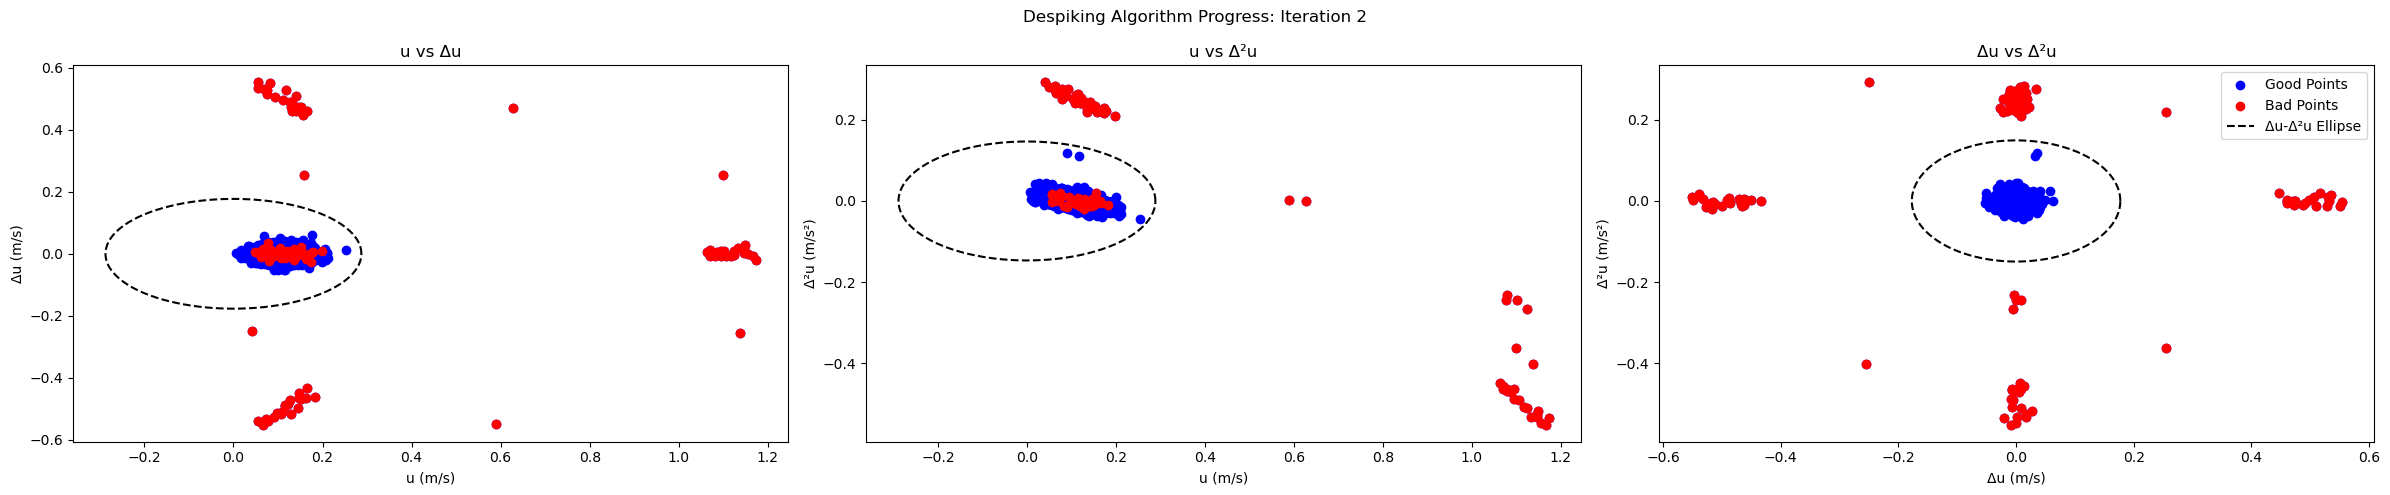

Iteration 2 complete.
Bad Indices = 34


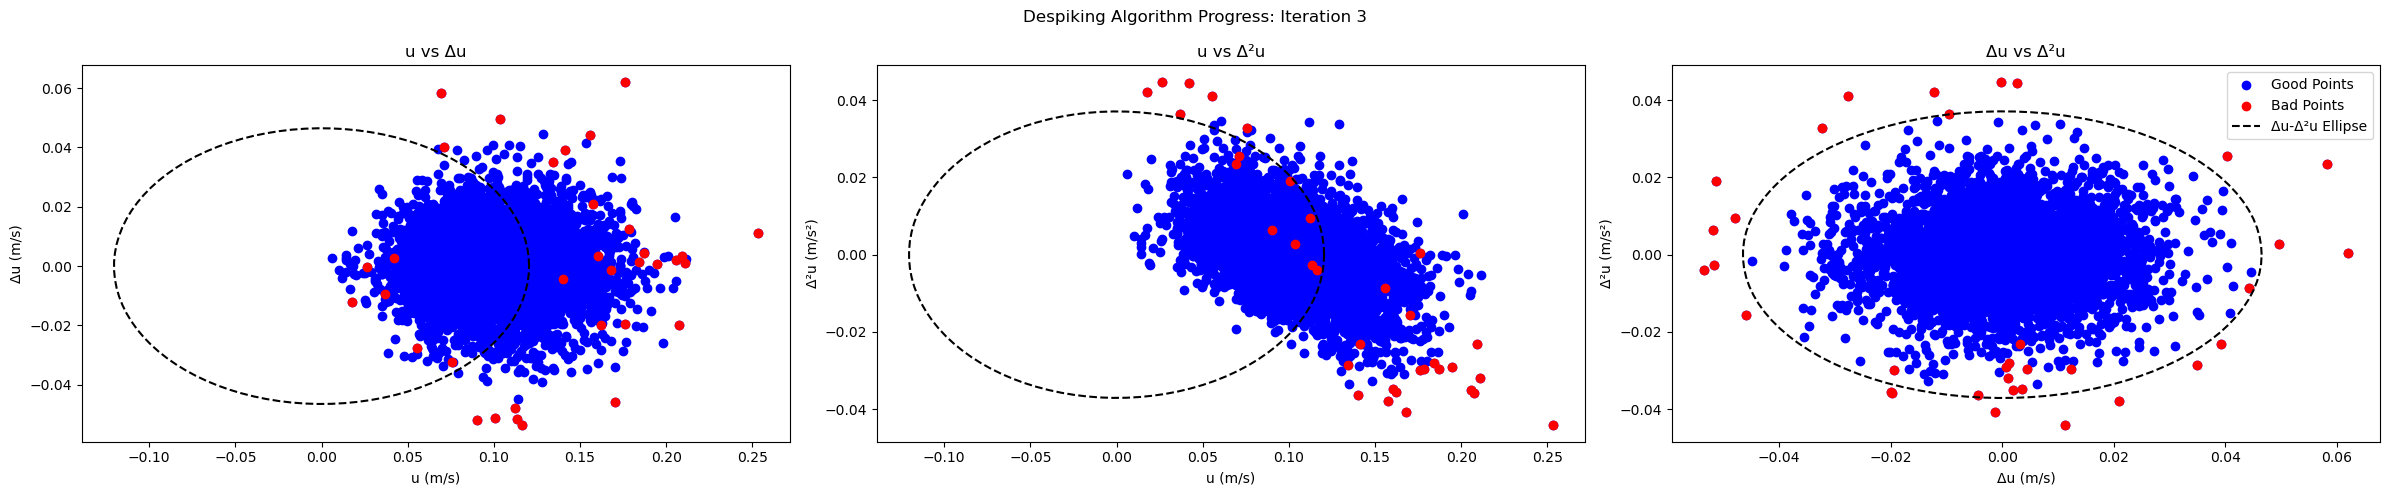

Iteration 3 complete.
Bad Indices = 3


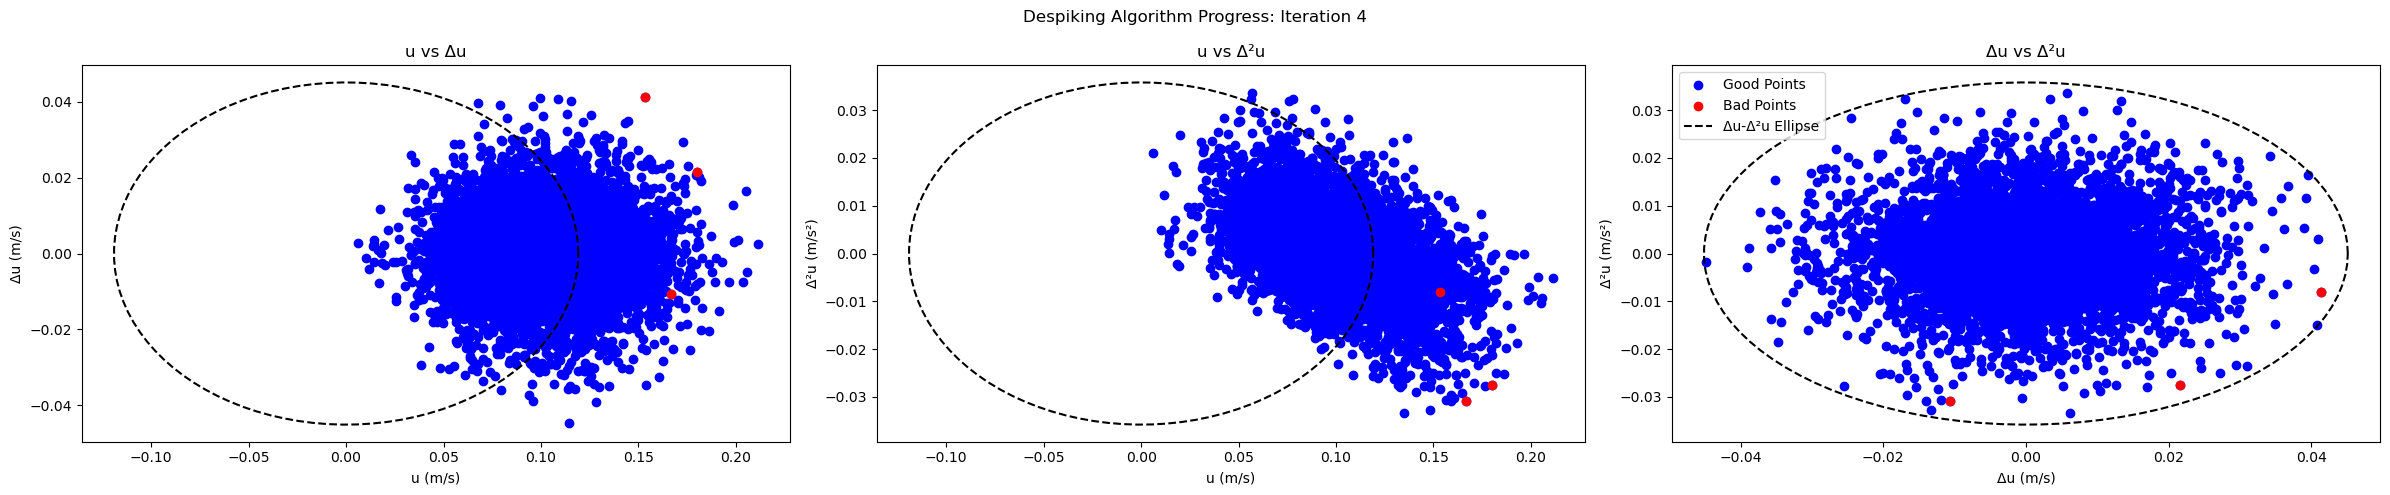

Iteration 4 complete.
Bad Indices = 1


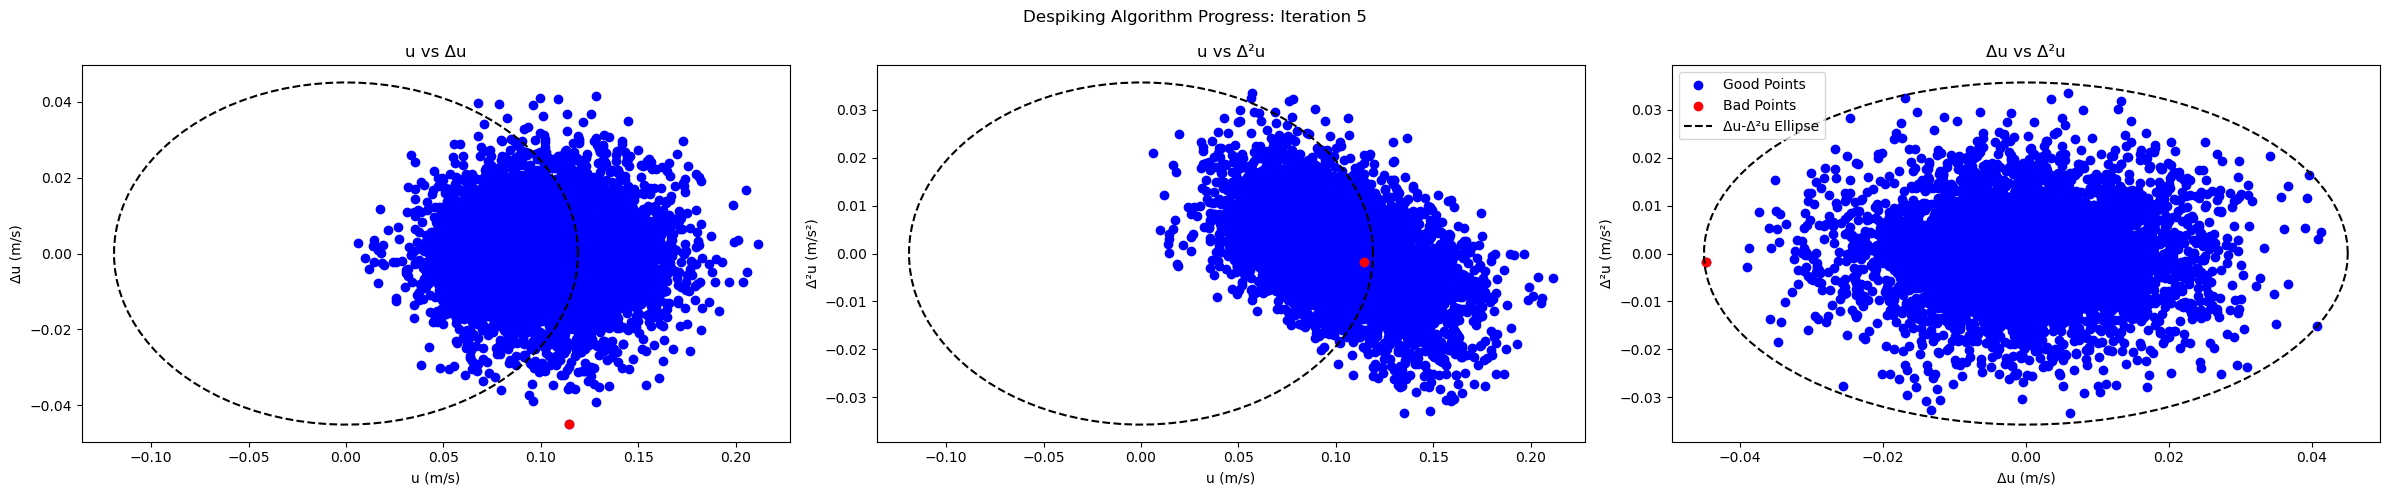

Iteration 5 complete.
Maximum iterations reached with 1 bad indices remaining.


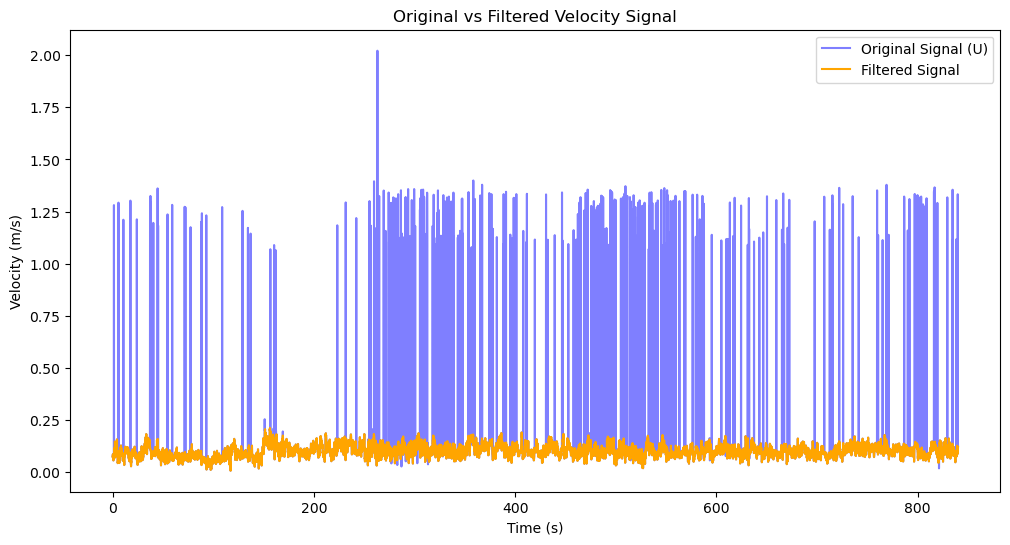

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        # Initialize the class with the path to the ADV data file.
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()
        self.u = data['U'].to_numpy()
        self.original_u = self.u.copy()
        self.calculate_derivatives_2()
# Part 1
    def plot_time_series_1(self):
        """Method to plot the time-series of the velocity."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.t, self.u, label="Velocity (U)", color="blue")
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Time Series Plot of Water Velocity')
        plt.legend()
        plt.show()

    def plot_histogram_1(self):
        """Method to plot a histogram of the velocity."""
        plt.figure(figsize=(8, 5))
        plt.hist(self.u, bins=30, edgecolor='black', color="skyblue")
        plt.xlabel('Velocity (m/s)')
        plt.ylabel('Frequency')
        plt.title('Histogram of Water Velocity')
        plt.show()

    def apply_threshold_1(self, threshold):
        """Method to apply a threshold and filter out 'bad' data."""
        self.u_filtered_simple = np.where(self.u > threshold, np.nan, self.u)
        nan_percentage = np.isnan(self.u_filtered_simple).mean() * 100
        print(f'{nan_percentage:.2f}% of the data set to NaN')

    def plot_1st_filtered_signal_1(self):
        """Method to plot the original signal vs the filtered signal."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.t, self.u, label="Original Signal", color="blue")
        plt.plot(self.t, self.u_filtered_simple, label="Filtered Signal", color="red", linestyle='--')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Original vs. Filtered Signal')
        plt.legend()
        plt.show()

# Part 2
    def calculate_derivatives_2(self):
        # Calculate first and second derivatives of velocity.
        self.dU = np.gradient(self.u)  # 1st derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # 2nd derivative (Δ²U)

    def calculate_standard_deviations_2(self):
        # Calculate standard deviations for velocity and its derivatives.
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)

    def calculate_lambda_2(self):
        """Calculate the universal maximum scaling factor λ."""
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes_2(self):
        # Calculate major and minor axes for ellipses.
        self.calculate_standard_deviations_2()
        self.calculate_lambda_2()
        
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))
        A = (self.lambda_max * self.sigma_U) ** 2
        B = (self.lambda_max * self.sigma_d2U) ** 2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)  

        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)    
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices_2(self):
        # Finding indices where data falls outside the bounds of ellipses.
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        # Check for bad indices for u-Δ²u ellipse
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        # Check for bad indices
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1        
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U
        print(f"Bad Indices = {np.sum(self.bad_indices)}")
            
    def apply_despiking_2(self):
        
        self.u[self.bad_indices] = np.nan
        # Interpolate over NaN values using linear interpolation to smooth the despiked data
        self.u = pd.Series(self.u).interpolate(method='linear').to_numpy()
        # After interpolation, recalculate derivatives for the new despiked data
        self.calculate_derivatives_2()
        
    def plot_progress_2(self, iteration):
        """Plot the data points and the ellipses at each iteration for all three relationships."""
        
        # Set up subplots
        fig, axs = plt.subplots(1, 3, figsize=(24, 5))
        fig.tight_layout()
        
        # u vs Δu plot (at left)
        axs[0].scatter(self.u, self.dU, label='Good Points', color='blue')
        axs[0].scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        axs[0].plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        axs[0].set_xlabel('u (m/s)')
        axs[0].set_ylabel('Δu (m/s)')
        axs[0].set_title('u vs Δu')

        # u vs Δ²u plot ( in middle)
        axs[1].scatter(self.u, self.d2U, label='Good Points', color='blue')
        axs[1].scatter(self.u[self.bad_indices], self.d2U[self.bad_indices], label='Bad Points', color='red')
        ellipse_u_d2U_x = self.a2 * np.cos(theta)
        ellipse_u_d2U_y = self.b2 * np.sin(theta)
        axs[1].plot(ellipse_u_d2U_x, ellipse_u_d2U_y, 'k--', label="u-Δ²u Ellipse")
        axs[1].set_xlabel('u (m/s)')
        axs[1].set_ylabel('Δ²u (m/s²)')
        axs[1].set_title('u vs Δ²u')

        # Δu vs Δ²u plot (at right)
        axs[2].scatter(self.dU, self.d2U, label='Good Points', color='blue')
        axs[2].scatter(self.dU[self.bad_indices], self.d2U[self.bad_indices], label='Bad Points', color='red')
        ellipse_dU_d2U_x = self.a3 * np.cos(theta)
        ellipse_dU_d2U_y = self.b3 * np.sin(theta)
        axs[2].plot(ellipse_dU_d2U_x, ellipse_dU_d2U_y, 'k--', label="Δu-Δ²u Ellipse")
        axs[2].set_xlabel('Δu (m/s)')
        axs[2].set_ylabel('Δ²u (m/s²)')
        axs[2].set_title('Δu vs Δ²u')

        
        fig.suptitle(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_2nd_filtered_signal_2(self):
        # Plot the original signal and the filtered signal.
        plt.figure(figsize=(12, 6))
        plt.plot(self.t, self.original_u, label='Original Signal (U)', color='blue', alpha=0.5)
        plt.plot(self.t, self.u, label='Filtered Signal', color='orange')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Original vs Filtered Velocity Signal')
        plt.legend()
        plt.show()

    def iterate_despiking_2(self, max_iterations, tolerance):
        # Iteratively despike until the number of bad points is below the tolerance.
        for i in range(max_iterations):
            self.find_bad_indices_2()
            self.plot_progress_2(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking_2()
            self.calculate_ellipse_axes_2()

            print(f"Iteration {i+1} complete.")
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")
        
        # Plot the original and filtered signal after despiking
        self.plot_2nd_filtered_signal_2()


adv_data = AdvData('adv.csv')
# 1st Part
adv_data.plot_time_series_1()
# Plot the histogram of the velocity
adv_data.plot_histogram_1()
adv_data.apply_threshold_1(0.2)
# Plot the original signal and filtered signal
adv_data.plot_1st_filtered_signal_1()

# 2nd Plot
adv_data.calculate_ellipse_axes_2()
adv_data.iterate_despiking_2(max_iterations=5, tolerance=1)


# Conclusion : My Comments

### Part 1:

1. The filtered signal showed a smoother trend compared to the noisy original signal. (Time series graphs)

2. Approximately 4.96% of data points were set to NaN due to the threshold condition.

3. The threshold effectively removed extreme outliers, enhancing signal clarity.

4. The method highlighted a difference between data cleaning and potential data loss.

### Part 2:

1. The Goring & Nikora algorithm took Maximum 5 iterations to converge.

2. The filtered signal displayed effective noise reduction while retaining data trends. (Using different scattered plots with ellipses)

3. Compared to visual outlier detection, the algorithm provided somewhat more objective filtering method.

4. The final filtered signal showcased improved continuity and fewer artifacts, enhancing overall data quality.